In [4]:
import sys
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
src_directory = current_dir.parent
sys.path.append(str(src_directory))

from income_predict import preprocessing, cleaning

In [5]:
parquet_path = src_directory / "data" / "census_income.parquet"

df_raw = pd.read_parquet(parquet_path)
print(df_raw.head())


   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [6]:
df_raw.info()
df_raw.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


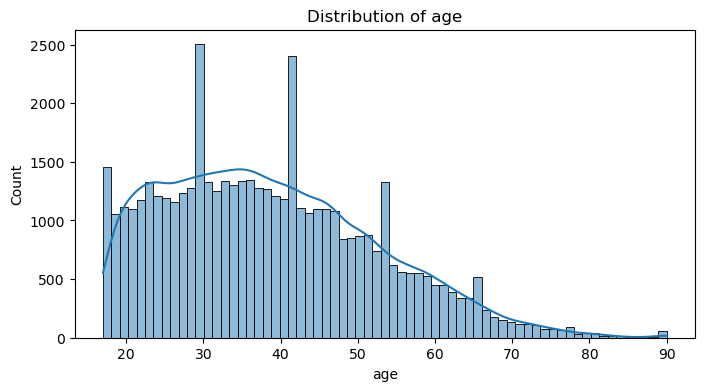

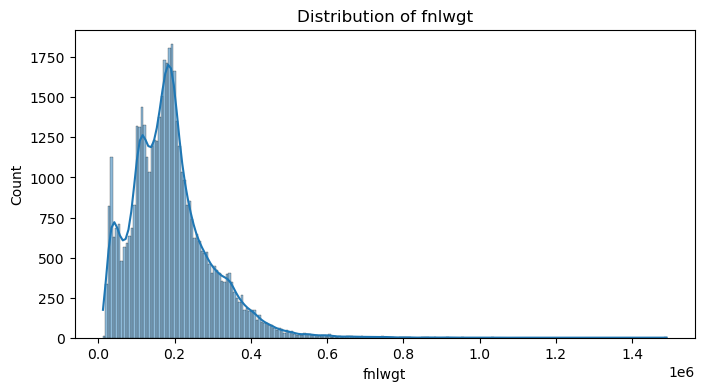

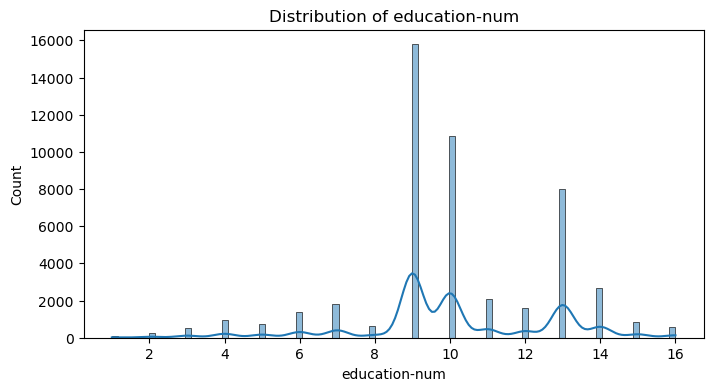

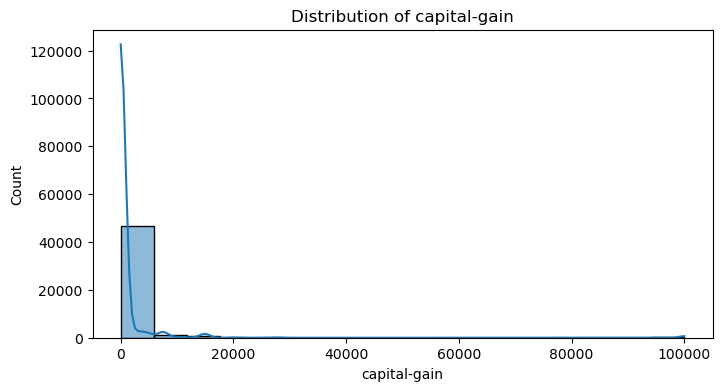

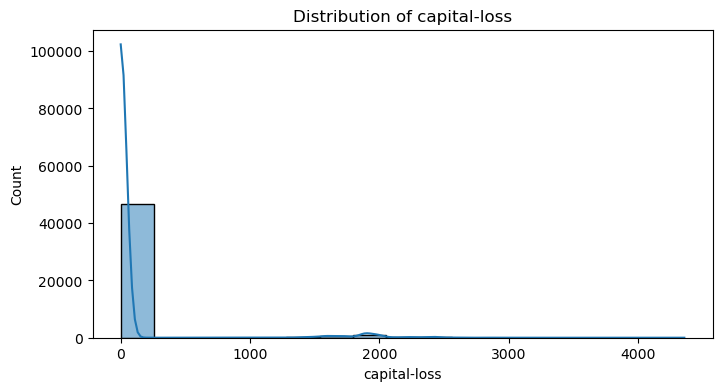

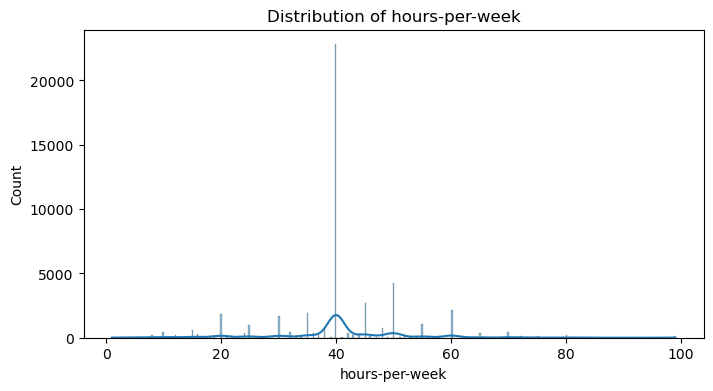

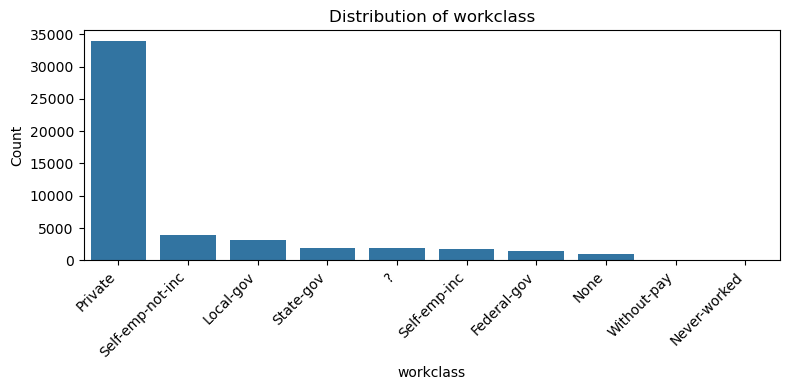

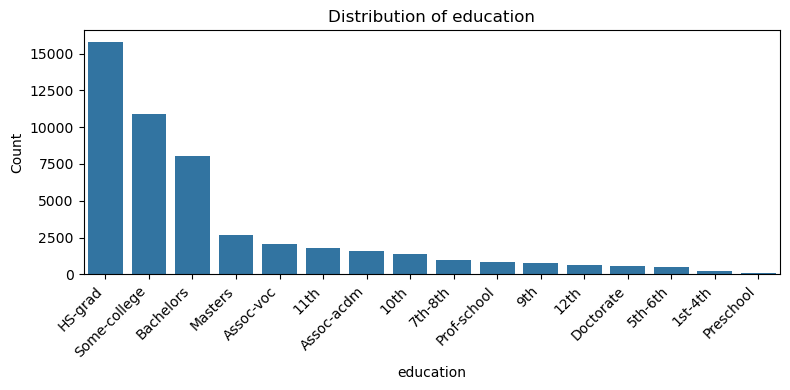

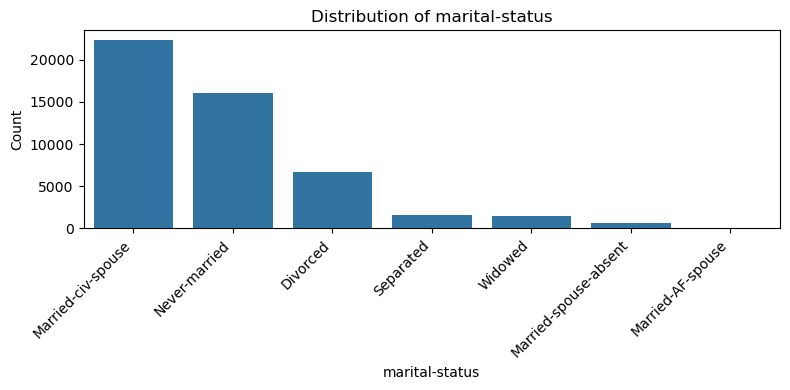

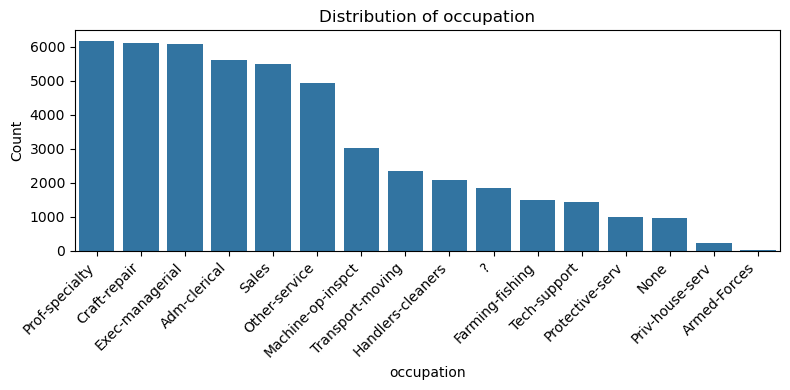

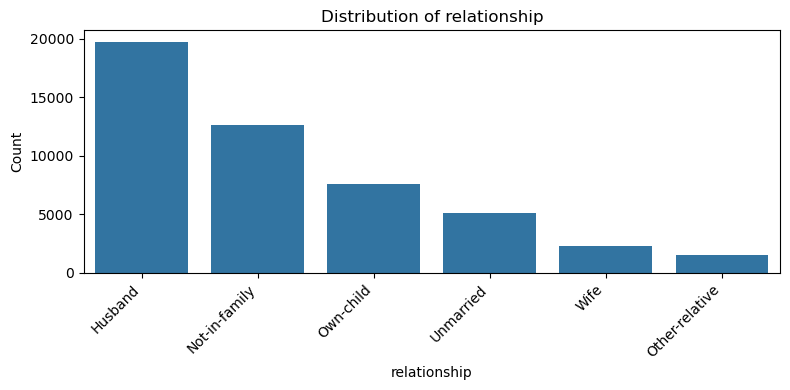

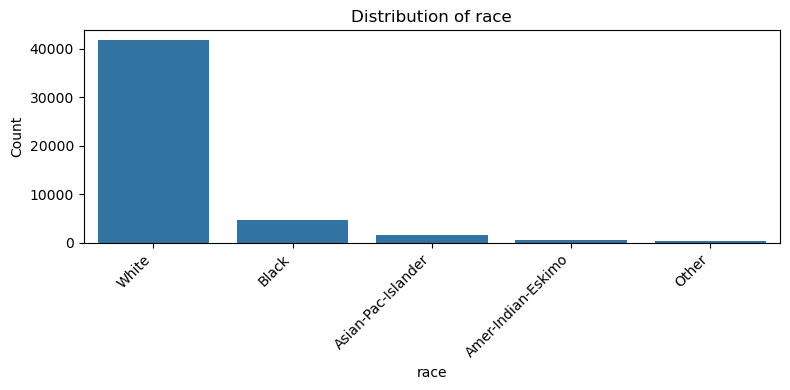

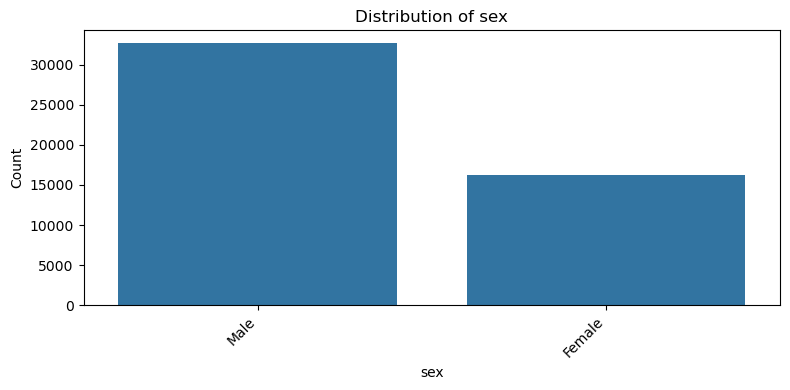

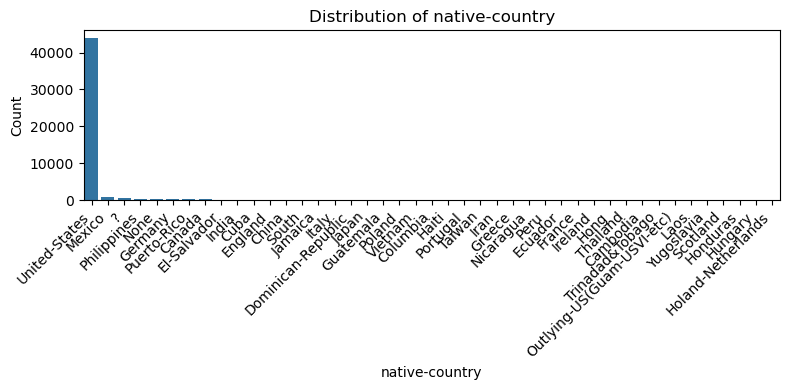

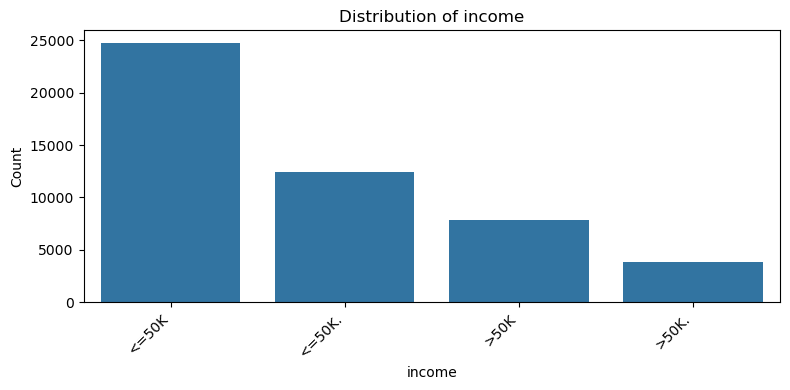

{'dtypes': age                int64
 workclass         object
 fnlwgt             int64
 education         object
 education-num      int64
 marital-status    object
 occupation        object
 relationship      object
 race              object
 sex               object
 capital-gain       int64
 capital-loss       int64
 hours-per-week     int64
 native-country    object
 income            object
 dtype: object,
 'description':                  age workclass        fnlwgt education  education-num  \
 count   48842.000000     47879  4.884200e+04     48842   48842.000000   
 unique           NaN         9           NaN        16            NaN   
 top              NaN   Private           NaN   HS-grad            NaN   
 freq             NaN     33906           NaN     15784            NaN   
 mean       38.643585       NaN  1.896641e+05       NaN      10.078089   
 std        13.710510       NaN  1.056040e+05       NaN       2.570973   
 min        17.000000       NaN  1.228500e+04      

In [7]:
#1. Describe your data.
preprocessing.get_data_description(df_raw)

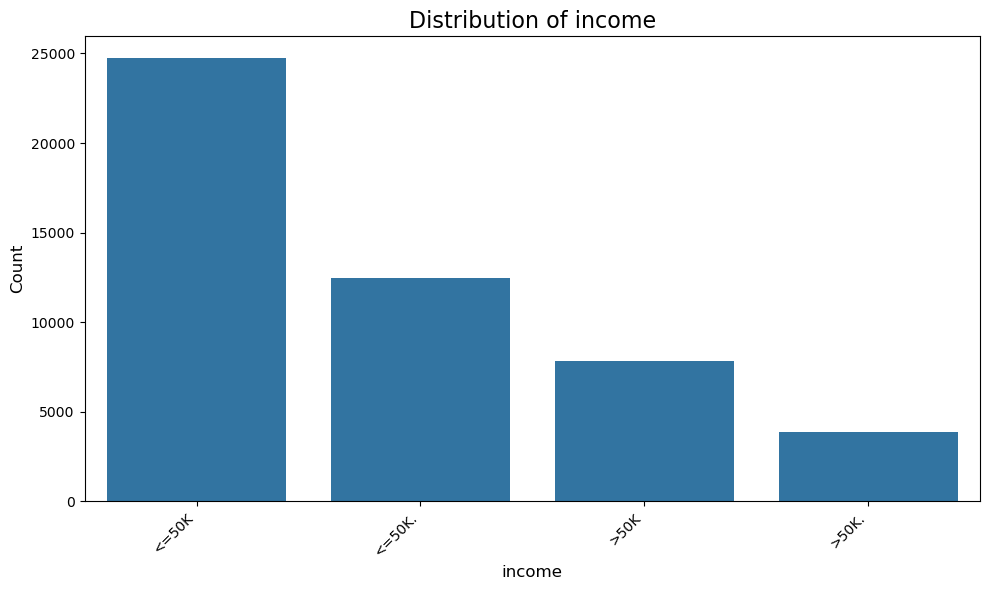

,Count,Percent
income,,
<=50K,24720,50.612178
<=50K.,12435,25.459645
>50K,7841,16.053806
>50K.,3846,7.874370


In [8]:
#2. What is the distribution of the target variable?
preprocessing.get_target_distribution(df_raw, 'income')


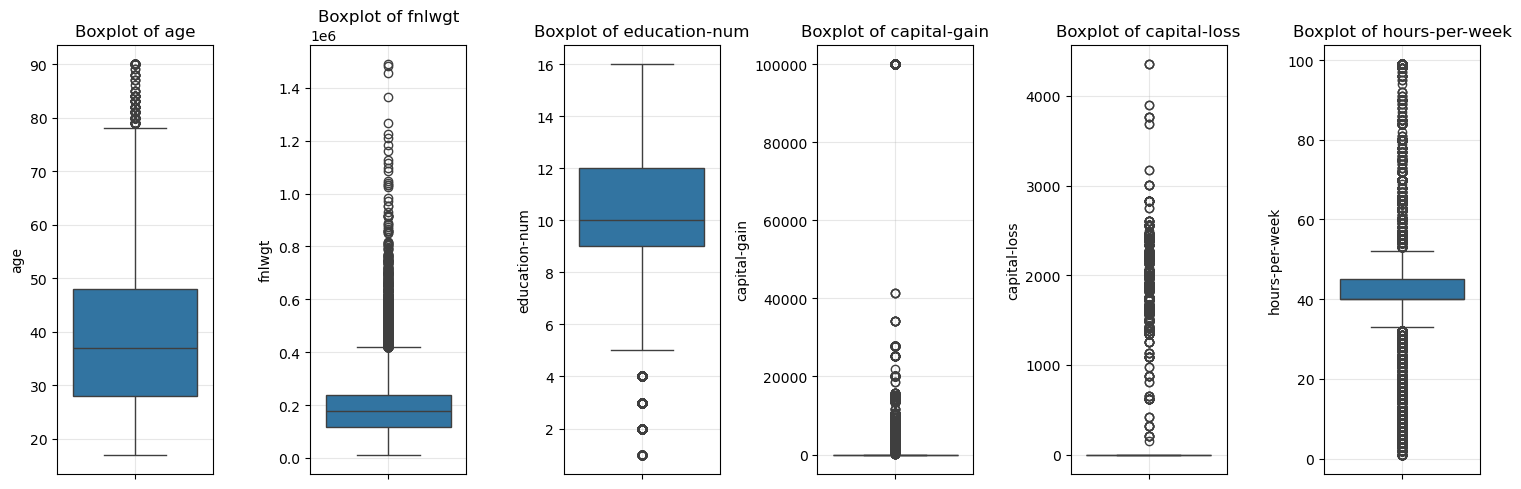

,Column,Outlier Count,Percent,Lower Bound,Upper Bound,Missing Values
5,hours-per-week,13496.0,27.631956,32.50,52.50,0
3,capital-gain,4035.0,8.261332,0.00,0.00,0
4,capital-loss,2282.0,4.672208,0.00,0.00,0
2,education-num,1794.0,3.673068,4.50,16.50,0
1,fnlwgt,1453.0,2.974899,-62586.75,417779.25,0
0,age,216.0,0.442242,-2.00,78.00,0
6,workclass,NaN,NaN,NaN,NaN,963
7,occupation,NaN,NaN,NaN,NaN,966
8,native-country,NaN,NaN,NaN,NaN,274


In [9]:
#3. Do we face outliers and missing values?
preprocessing.get_outliers_summary(df_raw)

In [10]:
# Cleaning pipeline i.e.:
# - Add unique ID column
# - Clean column names (e.g. 'capital-gain' -> 'capital_gain')
# - Remove redundant columns
# - clean an binarize income data (1 for '>50K', 0 for '=<50K')
# - Replace '?' with NaN
# - trim whitespace from all str values
# - Transform education categories into ordered categories (e.g. 'Preschool' < '1st-4th' < ... < 'Doctorate')
# - Transform capital-gain and capital-loss into a single column capital-net
df_clean = cleaning.full_clean(df_raw)
df_clean.columns.tolist()

['unique_id',
 'age',
 'work_class',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'hours_per_week',
 'native_country',
 'high_income',
 'capital_net']

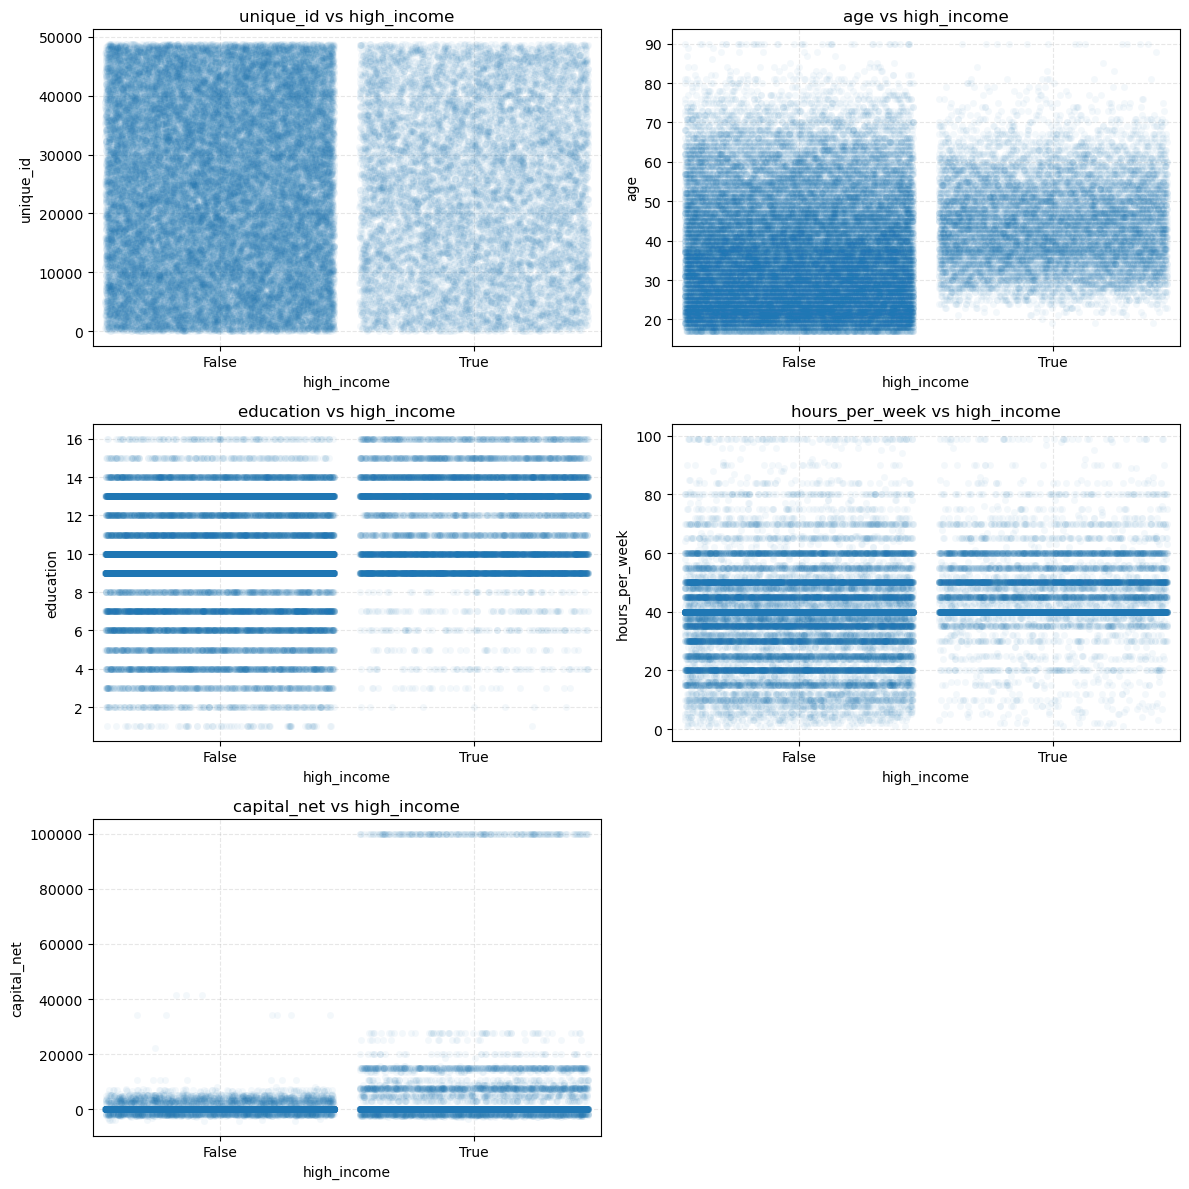

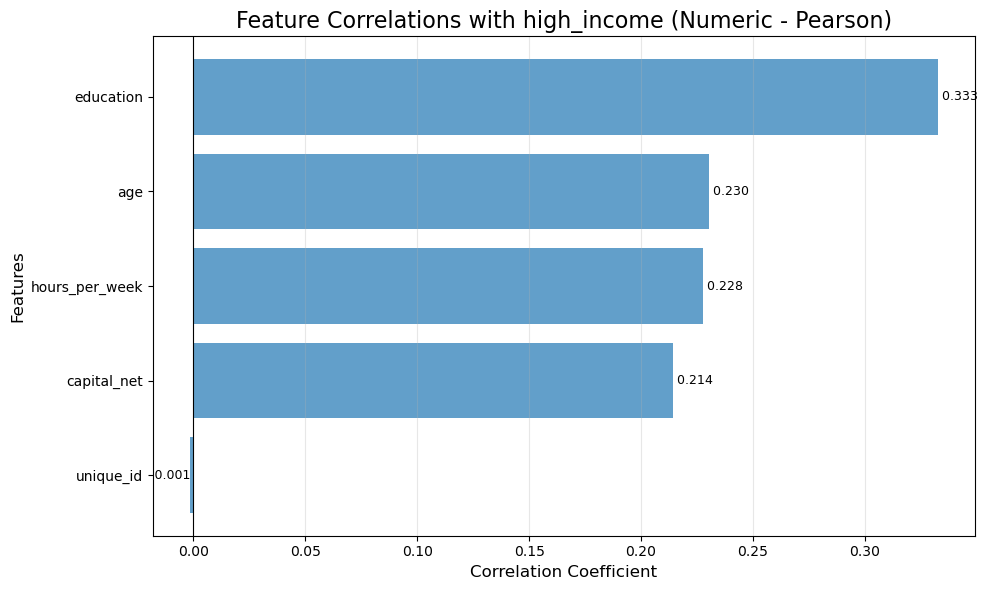

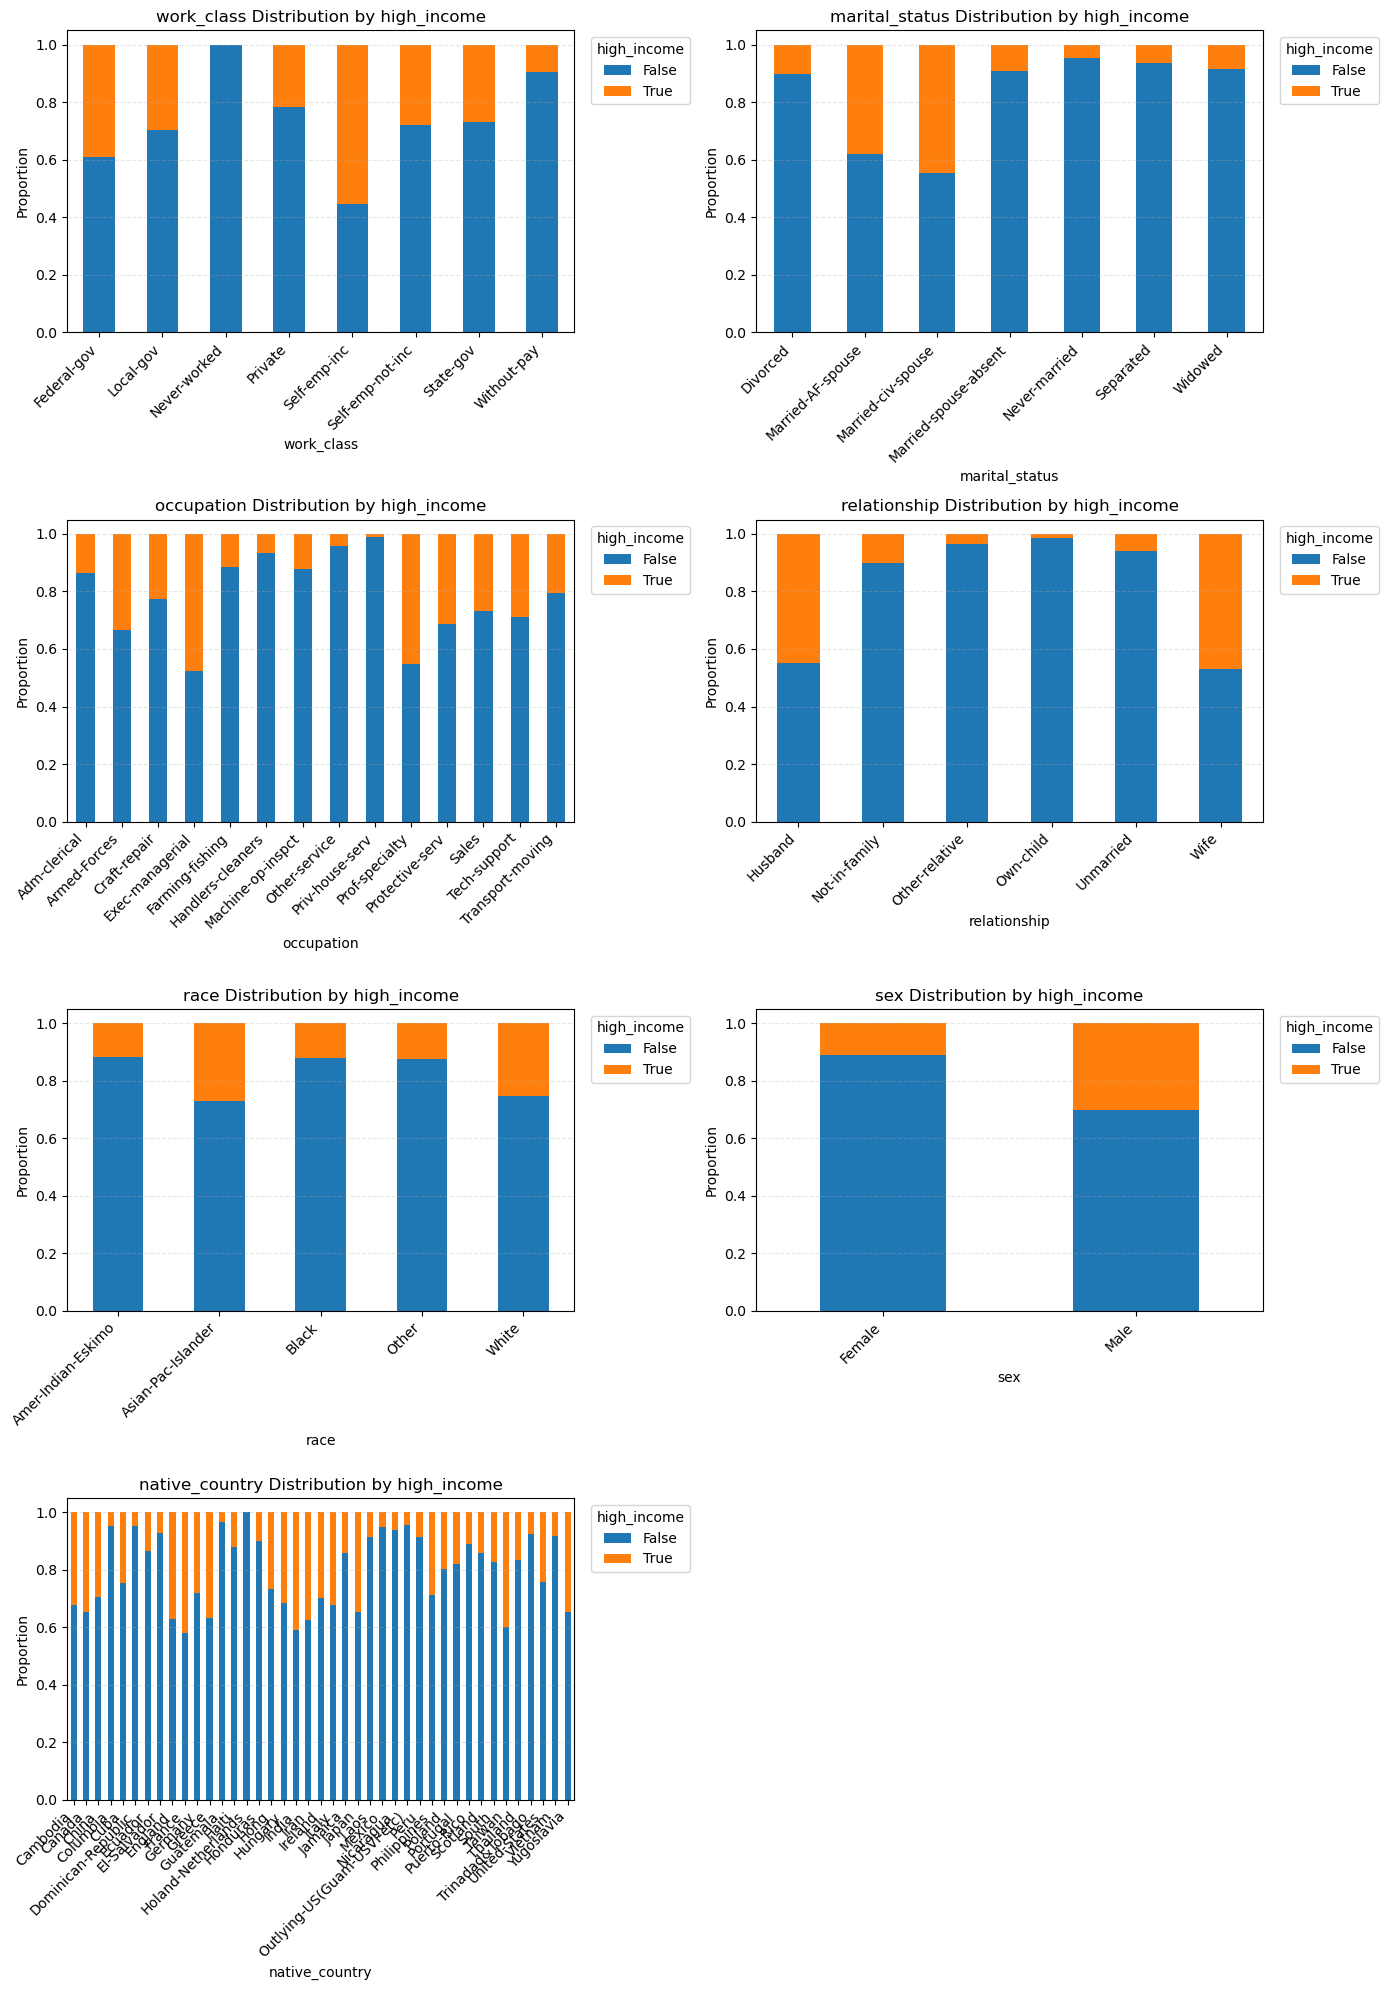

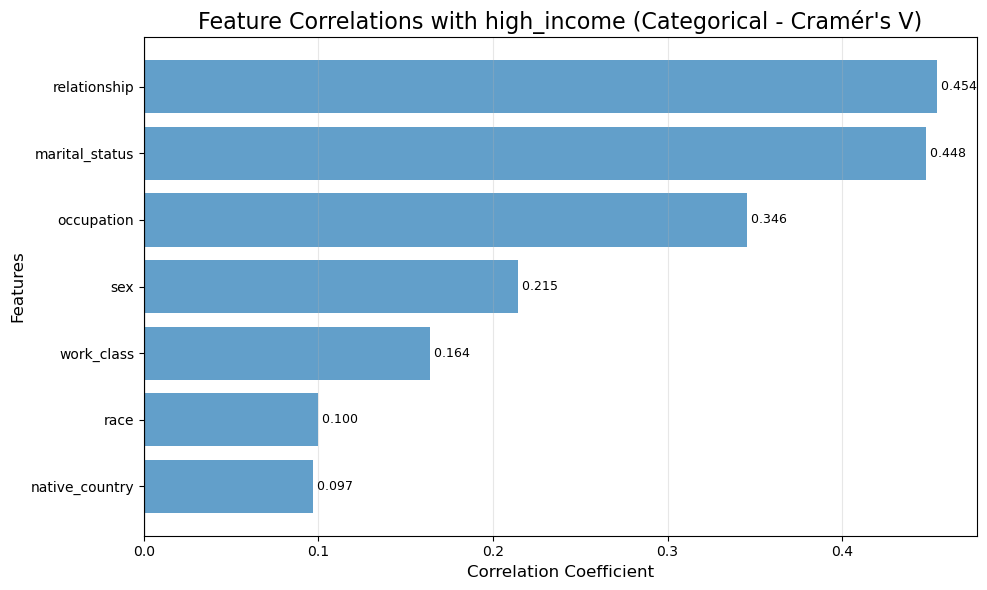

{'numeric': education         0.332613
 age               0.230369
 hours_per_week    0.227687
 capital_net       0.214356
 unique_id        -0.001475
 Name: high_income, dtype: float64,
 'categorical': relationship      0.454487
 marital_status    0.448302
 occupation        0.345725
 sex               0.214577
 work_class        0.164041
 race              0.099857
 native_country    0.096966
 dtype: float64}

In [11]:
#4. How do specific features correlate with the target variable?
preprocessing.get_feature_correlations(df_clean, 'high_income')